In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import models, transforms
import seaborn as sns
import matplotlib.pyplot as plt
!pip install timm
import timm

# Load Data

In [2]:
train_path=r'/kaggle/input/face-expression-recognition-dataset/images/train'
test_path=r'/kaggle/input/face-expression-recognition-dataset/images/validation'

In [3]:
def load_data(path):
    data = []
    labels = []
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            data.append(img)
            labels.append(label)
    return data, labels

train_data, train_labels = load_data(train_path)
test_data, test_labels=load_data(test_path)

In [4]:
print(f'Train data length: {len(train_data)}, Train labels length: {len(train_labels)}')
print(f'Test data length: {len(test_data)}, Test labels length: {len(test_labels)}')

Train data length: 28821, Train labels length: 28821
Test data length: 7066, Test labels length: 7066


In [5]:
train_df = pd.DataFrame({'image': train_data, 'label': train_labels})
test_df = pd.DataFrame({'image': test_data, 'label': test_labels})

In [6]:
print(train_df['label'].unique())
num_classes=len(train_df['label'].unique())

['surprise' 'fear' 'angry' 'neutral' 'sad' 'disgust' 'happy']


## Encoding Labels

In [7]:
label_map = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

## Taking Random Subset & Train Test Split

In [8]:
number_used = 6000
subset_train_df = train_df.sample(n=number_used, random_state=42).reset_index(drop=True)
subset_test_df = test_df.sample(n=number_used, random_state=42).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    subset_train_df['image'].values, 
    subset_train_df['label'].values, 
    test_size=0.2, 
    random_state=42
)

train_subset_df = pd.DataFrame({'image': X_train, 'label': y_train})
test_subset_df = pd.DataFrame({'image': X_test, 'label': y_test})

# Needed Functions & Classes

## Creating Yaml File

In [9]:
config_content = f"""
train: {train_path}
val: {test_path}

nc: 7

names:
  0: angry
  1: disgust
  2: fear
  3: happy
  4: neutral
  5: sad
  6: surprise
"""

# Write the configuration to the file
with open("dataset.yaml", "w") as f:
    f.write(config_content)

yaml_file_path = '/kaggle/working/dataset.yaml'

## Creating Transformers

In [10]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Creating Dataset & Loaders

In [11]:
train_dataset = CustomDataset(train_subset_df, transform=transform)
test_dataset = CustomDataset(test_subset_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluations Tracking & Training Functions

1. Model Evaluation: it returns the actual value and the predicted one
2. Confusion Matrix
3. Metrics planning for train/tess loss and accuracy

In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=label_map.keys()))
    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['test_loss'], label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['test_acc'], label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Model Training

In [13]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)  # Move to GPU
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)  # Move to GPU
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_acc = correct / total

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    return history

## Logging Metrics Functions

In [14]:
# def log_metrics_to_tensorboard(writer, y_true, y_pred, history):
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')

#     writer.add_scalar("Accuracy", accuracy)
#     writer.add_scalar("Precision", precision)
#     writer.add_scalar("Recall", recall)
#     writer.add_scalar("F1_score", f1)

#     for epoch, (train_loss, test_loss, train_acc, test_acc) in enumerate(zip(history['train_loss'], history['test_loss'], history['train_acc'], history['test_acc']), 1):
#         writer.add_scalar(f"train_loss_epoch_{epoch}", train_loss)
#         writer.add_scalar(f"test_loss_epoch_{epoch}", test_loss)
#         writer.add_scalar(f"train_acc_epoch_{epoch}", train_acc)
#         writer.add_scalar(f"test_acc_epoch_{epoch}", test_acc)

# Training Models and Tensorboard Tracking

Few models to consider: 
1. Resnet50
2. DenseNet
3. InceptionV3
4. Vision Transformers ViT

In [15]:
number_epochs=25
learning_rate=0.001

## ViT 

In [16]:
def get_vit_model(num_classes):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_vit_model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=number_epochs)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 1/25, Train Loss: 2.2293, Test Loss: 1.9105, Train Acc: 0.1940, Test Acc: 0.2475


Epoch 2/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 2/25, Train Loss: 1.8787, Test Loss: 1.8207, Train Acc: 0.2152, Test Acc: 0.2467


Epoch 3/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 3/25, Train Loss: 1.8269, Test Loss: 1.8073, Train Acc: 0.2256, Test Acc: 0.2467


Epoch 4/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 4/25, Train Loss: 1.8169, Test Loss: 1.8419, Train Acc: 0.2248, Test Acc: 0.1725


Epoch 5/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 5/25, Train Loss: 1.8090, Test Loss: 1.7966, Train Acc: 0.2323, Test Acc: 0.2450


Epoch 6/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 6/25, Train Loss: 1.7990, Test Loss: 1.8130, Train Acc: 0.2348, Test Acc: 0.2283


Epoch 7/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 7/25, Train Loss: 1.7919, Test Loss: 1.7929, Train Acc: 0.2525, Test Acc: 0.2375


Epoch 8/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 8/25, Train Loss: 1.7888, Test Loss: 1.7960, Train Acc: 0.2481, Test Acc: 0.2467


Epoch 9/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 9/25, Train Loss: 1.7829, Test Loss: 1.8006, Train Acc: 0.2504, Test Acc: 0.2475


Epoch 10/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 10/25, Train Loss: 1.7848, Test Loss: 1.7883, Train Acc: 0.2571, Test Acc: 0.2617


Epoch 11/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 11/25, Train Loss: 1.7872, Test Loss: 1.7886, Train Acc: 0.2487, Test Acc: 0.2650


Epoch 12/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 12/25, Train Loss: 1.7800, Test Loss: 1.8060, Train Acc: 0.2444, Test Acc: 0.2442


Epoch 13/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 13/25, Train Loss: 1.7853, Test Loss: 1.8268, Train Acc: 0.2433, Test Acc: 0.2300


Epoch 14/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 14/25, Train Loss: 1.7826, Test Loss: 1.8120, Train Acc: 0.2456, Test Acc: 0.2167


Epoch 15/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 15/25, Train Loss: 1.7868, Test Loss: 1.7931, Train Acc: 0.2462, Test Acc: 0.2550


Epoch 16/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 16/25, Train Loss: 1.7862, Test Loss: 1.7999, Train Acc: 0.2554, Test Acc: 0.2592


Epoch 17/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 17/25, Train Loss: 1.7864, Test Loss: 1.7960, Train Acc: 0.2542, Test Acc: 0.2558


Epoch 18/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 18/25, Train Loss: 1.7887, Test Loss: 1.7920, Train Acc: 0.2381, Test Acc: 0.2017


Epoch 19/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 19/25, Train Loss: 1.7864, Test Loss: 1.7982, Train Acc: 0.2383, Test Acc: 0.2492


Epoch 20/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 20/25, Train Loss: 1.7908, Test Loss: 1.8084, Train Acc: 0.2425, Test Acc: 0.2108


Epoch 21/25: 100%|██████████| 150/150 [01:31<00:00,  1.65it/s]


Epoch 21/25, Train Loss: 1.7849, Test Loss: 1.8065, Train Acc: 0.2510, Test Acc: 0.2442


Epoch 22/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 22/25, Train Loss: 1.7806, Test Loss: 1.7983, Train Acc: 0.2494, Test Acc: 0.2458


Epoch 23/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 23/25, Train Loss: 1.7810, Test Loss: 1.8066, Train Acc: 0.2479, Test Acc: 0.2417


Epoch 24/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 24/25, Train Loss: 1.7861, Test Loss: 1.7904, Train Acc: 0.2546, Test Acc: 0.2533


Epoch 25/25: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


Epoch 25/25, Train Loss: 1.7818, Test Loss: 1.8077, Train Acc: 0.2444, Test Acc: 0.2367


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    surprise       0.32      0.10      0.15       121
        fear       0.00      0.00      0.00       155
       angry       0.00      0.00      0.00       180
     neutral       0.17      0.27      0.21       220
         sad       0.20      0.00      0.01       204
     disgust       0.00      0.00      0.00        24
       happy       0.26      0.71      0.39       296

    accuracy                           0.24      1200
   macro avg       0.14      0.16      0.11      1200
weighted avg       0.16      0.24      0.15      1200



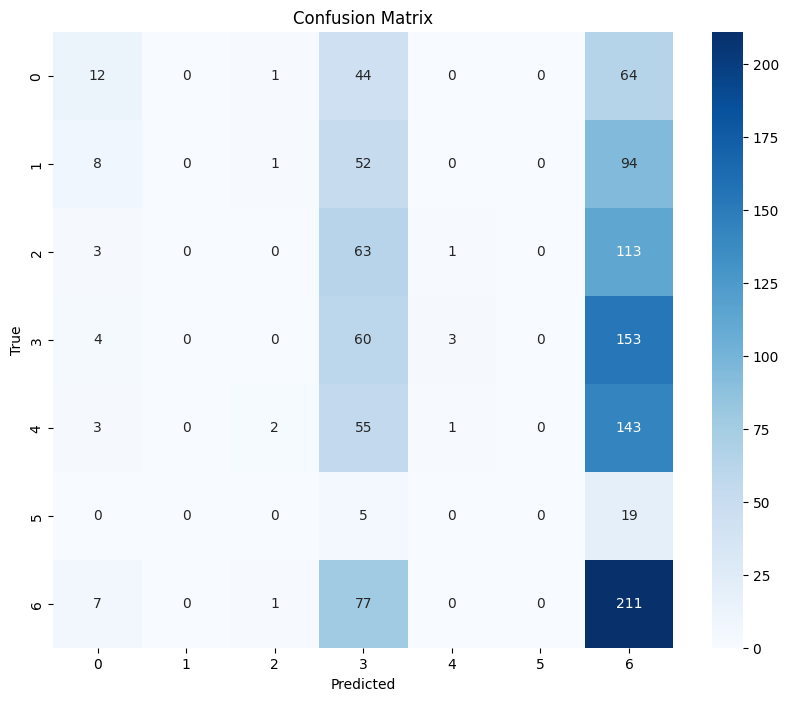

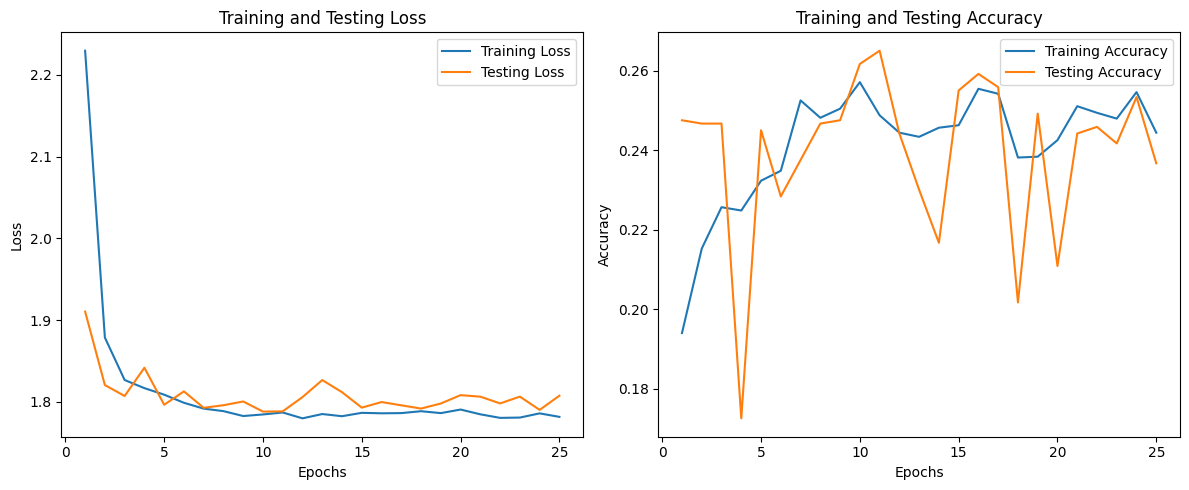

In [17]:
y_true, y_pred = evaluate_model(model, test_loader)
plot_confusion_matrix(y_true, y_pred, classes=list(label_map.keys()))
plot_metrics(history)

## ResNet50

In [19]:
def get_resnet50_model(num_classes):
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = get_resnet50_model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=number_epochs)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]
Epoch 1/25: 100%|██████████| 150/150 [00:28<00:00,  5.24it/s]


Epoch 1/25, Train Loss: 1.6844, Test Loss: 1.5394, Train Acc: 0.3227, Test Acc: 0.3667


Epoch 2/25: 100%|██████████| 150/150 [00:28<00:00,  5.30it/s]


Epoch 2/25, Train Loss: 1.4894, Test Loss: 1.4712, Train Acc: 0.4156, Test Acc: 0.4117


Epoch 3/25: 100%|██████████| 150/150 [00:28<00:00,  5.30it/s]


Epoch 3/25, Train Loss: 1.4183, Test Loss: 1.5317, Train Acc: 0.4494, Test Acc: 0.3917


Epoch 4/25: 100%|██████████| 150/150 [00:28<00:00,  5.27it/s]


Epoch 4/25, Train Loss: 1.3289, Test Loss: 1.4284, Train Acc: 0.4823, Test Acc: 0.4558


Epoch 5/25: 100%|██████████| 150/150 [00:28<00:00,  5.27it/s]


Epoch 5/25, Train Loss: 1.2851, Test Loss: 1.4483, Train Acc: 0.5096, Test Acc: 0.4425


Epoch 6/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 6/25, Train Loss: 1.2003, Test Loss: 1.3806, Train Acc: 0.5396, Test Acc: 0.4717


Epoch 7/25: 100%|██████████| 150/150 [00:28<00:00,  5.27it/s]


Epoch 7/25, Train Loss: 1.1211, Test Loss: 1.4358, Train Acc: 0.5815, Test Acc: 0.4858


Epoch 8/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 8/25, Train Loss: 1.0295, Test Loss: 1.8850, Train Acc: 0.6158, Test Acc: 0.4100


Epoch 9/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 9/25, Train Loss: 0.9372, Test Loss: 1.4785, Train Acc: 0.6479, Test Acc: 0.4783


Epoch 10/25: 100%|██████████| 150/150 [00:28<00:00,  5.30it/s]


Epoch 10/25, Train Loss: 0.8547, Test Loss: 1.4036, Train Acc: 0.6783, Test Acc: 0.5000


Epoch 11/25: 100%|██████████| 150/150 [00:28<00:00,  5.28it/s]


Epoch 11/25, Train Loss: 0.6983, Test Loss: 1.6038, Train Acc: 0.7344, Test Acc: 0.4675


Epoch 12/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 12/25, Train Loss: 0.5273, Test Loss: 1.7939, Train Acc: 0.8071, Test Acc: 0.4708


Epoch 13/25: 100%|██████████| 150/150 [00:28<00:00,  5.28it/s]


Epoch 13/25, Train Loss: 0.4357, Test Loss: 1.9922, Train Acc: 0.8423, Test Acc: 0.4450


Epoch 14/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 14/25, Train Loss: 0.3388, Test Loss: 1.9503, Train Acc: 0.8738, Test Acc: 0.4817


Epoch 15/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 15/25, Train Loss: 0.2448, Test Loss: 2.3114, Train Acc: 0.9198, Test Acc: 0.4717


Epoch 16/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 16/25, Train Loss: 0.1991, Test Loss: 2.5117, Train Acc: 0.9275, Test Acc: 0.4958


Epoch 17/25: 100%|██████████| 150/150 [00:28<00:00,  5.28it/s]


Epoch 17/25, Train Loss: 0.1709, Test Loss: 2.4883, Train Acc: 0.9433, Test Acc: 0.4750


Epoch 18/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 18/25, Train Loss: 0.1355, Test Loss: 2.5938, Train Acc: 0.9558, Test Acc: 0.4917


Epoch 19/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 19/25, Train Loss: 0.1356, Test Loss: 2.4197, Train Acc: 0.9544, Test Acc: 0.4958


Epoch 20/25: 100%|██████████| 150/150 [00:28<00:00,  5.27it/s]


Epoch 20/25, Train Loss: 0.1228, Test Loss: 2.5254, Train Acc: 0.9565, Test Acc: 0.4883


Epoch 21/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 21/25, Train Loss: 0.0784, Test Loss: 3.1809, Train Acc: 0.9735, Test Acc: 0.4733


Epoch 22/25: 100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Epoch 22/25, Train Loss: 0.0941, Test Loss: 2.7208, Train Acc: 0.9688, Test Acc: 0.4683


Epoch 23/25: 100%|██████████| 150/150 [00:28<00:00,  5.30it/s]


Epoch 23/25, Train Loss: 0.0790, Test Loss: 2.6420, Train Acc: 0.9733, Test Acc: 0.4867


Epoch 24/25: 100%|██████████| 150/150 [00:28<00:00,  5.27it/s]


Epoch 24/25, Train Loss: 0.0883, Test Loss: 3.0419, Train Acc: 0.9702, Test Acc: 0.4942


Epoch 25/25: 100%|██████████| 150/150 [00:28<00:00,  5.30it/s]


Epoch 25/25, Train Loss: 0.0930, Test Loss: 2.7957, Train Acc: 0.9685, Test Acc: 0.4833


              precision    recall  f1-score   support

    surprise       0.66      0.64      0.65       121
        fear       0.30      0.32      0.31       155
       angry       0.39      0.24      0.30       180
     neutral       0.42      0.50      0.46       220
         sad       0.33      0.30      0.32       204
     disgust       0.50      0.08      0.14        24
       happy       0.66      0.80      0.72       296

    accuracy                           0.48      1200
   macro avg       0.47      0.41      0.41      1200
weighted avg       0.47      0.48      0.47      1200



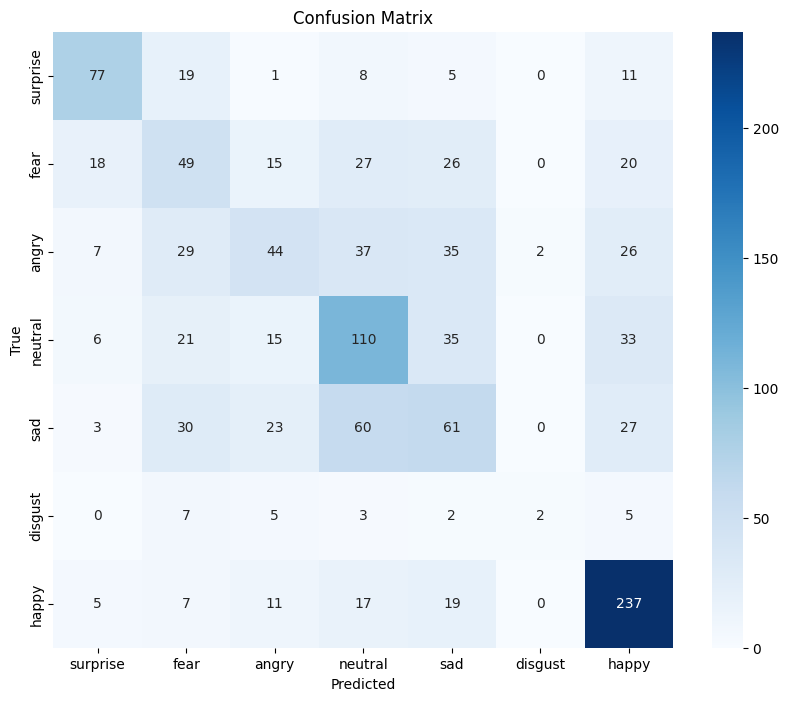

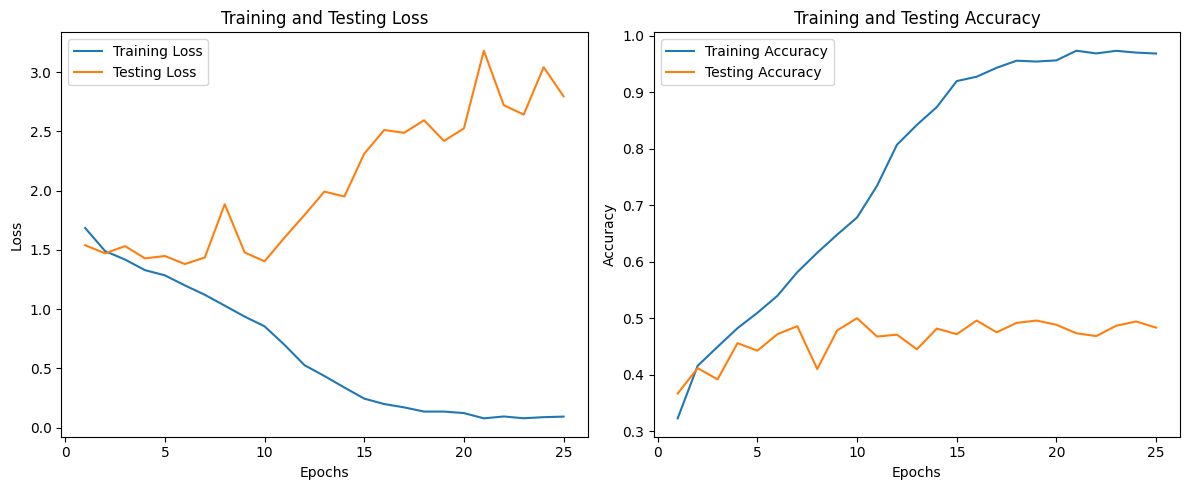

In [20]:
y_true, y_pred = evaluate_model(model, test_loader)
plot_confusion_matrix(y_true, y_pred, classes=list(label_map.keys()))
plot_metrics(history)

## NasNet


NASNet is a type of convolutional neural network discovered through neural architecture search. The building blocks consist of normal and reduction cells.

In [36]:
def get_nasnet_model(num_classes):
    model = timm.create_model('efficientnet_lite0', pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_nasnet_model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=number_epochs)


model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 21.12 MiB is free. Process 3275 has 15.87 GiB memory in use. Of the allocated memory 14.30 GiB is allocated by PyTorch, and 1.25 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
y_true, y_pred = evaluate_model(model, test_loader)
plot_confusion_matrix(y_true, y_pred, classes=list(label_map.keys()))
plot_metrics(history)

# Zipping the Logs

In [ ]:
# shutil.make_archive('/kaggle/working/tensorboard_logs', 'zip', '/kaggle/working/tensorboard_logs')
# print("tensorboard_logs.zip file created successfully")3